Questions guiding analysis:
* What are some trends in smart device usage?
* How could these trends apply to Bellabeat customers?
* How could these trends help influence Bellabeat marketing strategy?
Produce a report with the following deliverables:
* A clear summary of the business task
* A description of all data sources used
* Documentation of any cleaning or manipulation of data
* A summary of your analysis
* Supporting visualizations and key findings
* You top high-level content recommendations based on you analysis

# **1. Ask**
**1.1 Key Stakeholders**
* Urška Sršen: Bellabeat's cofounder and Chief Creative Officer.
* Sando Mur: Mathematician and Bellabeat cofounder; key member of the Bellabeat executive team
* Bellabeat Marketing analytics team: A team of data analysts responsible for collecting, analyzing, and reporting data that helped guide Bellabeat's marketing strategy.

**1.2 The Business Task**
Analyze trends on how consumers use other non-Bellabeat smart wearable devices. Apply such trends to Bellabeat products and customers to influence marketing strategy.


# **2. Prepare**
**2.1 About the Data Set**
The data set used is public domain, avaible on Kaggle courtesy of Mobius. It contains personal fitness tracker from thirty fitbit users that consented to the submission of personal tracker data, including minute-level output for physical activity, heart rate, and sleep monitoring. The content was generated by respondents to a distributed survey via Amazon Mechanical Turk between 03.12.2016-05.12.2016. Variation between output represents use of different types of Fitbit trackers and individual tracking behaviors / preferences.

**2.2 Data Organization**
It includes information about daily activity, steps, and heart rate that can be used to explore users’ habits throughout 18 seperate CSV documents. Each different CSV file stores information on a particular data aspect the watch tracks. It is in long format since each row is an observation at a different time per subject.

**2.3 Data Credibility and Limitations**
Per the Central Limit Theorem a sample size of 30, is enough to see statistically significant results. However, due to the way the data was collected (by survery) there is a chance of there being a sampling bias. Since we do not know the demographics there is a chance the sample is not representative of the population. Another limitation is that the data is now not current since the survery was conducted 6 years  ago.

# **3. Process**
I will use R to process the data because the size of the data and to create visualizations.
#### **3.1 Loading Packages**

In [1]:
library(tidyverse)
library(lubridate)
library(scales)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




#### **3.2 Importing Datasets**
I will be focusaing on these three datasets, since I am intrested peoples sleep and daily activity. I will also be using the hourlySteps dataset to see when people tend to walk the most.

In [2]:
raw_activity <- read_csv(file= "dailyActivity_merged.csv")
raw_sleep <- read_csv(file= "sleepDay_merged.csv")
raw_hourlySteps <- read_csv("hourlySteps_merged.csv")

Rows: 940 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ActivityDate
dbl (14): Id, TotalSteps, TotalDistance, TrackerDistance, LoggedActivitiesDi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 413 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): SleepDay
dbl (4): Id, TotalSleepRecords, TotalMinutesAsleep, TotalTimeInBed

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 22099 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): ActivityHour
dbl (2): Id, StepTotal

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

#### **3.3 Cleaning**
First, I verified the number of unique users in each dataset. We need a sample size of at least 30 in order for the central limit theorem to hold true. Activity and hourlySteps each have 33, while sleep only has 24. However, since this is only for practive I will still use it. In the real world I would recommend we try to gather more sleep data.  
Next, I removed duplicated and any instance where the same Id logged more than once per day or hour. 3 dupliacte rows were removed from the sleep dataset.  
Finally, I checked for any NA values, but luckly there weren't any.

In [3]:
# Verifying unique number of users
n_distinct(raw_activity$Id)
n_distinct(raw_sleep$Id)
n_distinct(raw_hourlySteps$Id)

# Removing duplicates
raw_activity <- raw_activity %>%
  distinct(Id, ActivityDate, .keep_all = TRUE)
raw_sleep <- raw_sleep %>%
  distinct(Id, SleepDay, .keep_all = TRUE)
raw_hourlySteps <- raw_hourlySteps %>%
  distinct(Id, ActivityHour, .keep_all = TRUE)

# Checking for NA values
any(is.na(raw_activity))
any(is.na(raw_sleep))
any(is.na(raw_hourlySteps))

[1] 33

[1] 24

[1] 33

[1] FALSE

[1] FALSE

[1] FALSE

#### **3.3 Formatting**
I converted the dates from characters into Dates in each of the datesets. For activity I also removed the columns I was not interested in so it was easier to work with. For sleep I added columns that converted the minutes asleep and in bed into hours.

In [4]:
#Converting to date and condensing
activity <- raw_activity %>%
  select(-c(TotalDistance,TrackerDistance, LoggedActivitiesDistance,
            VeryActiveDistance, ModeratelyActiveDistance, LightActiveDistance,
            SedentaryActiveDistance)) %>%
  mutate(ActivityDate = as.Date(ActivityDate, format = "%m/%d/%Y")) %>%
  rename(Date = ActivityDate)

#Converting to date and minutes into hours
sleep <- raw_sleep %>%
  mutate(SleepDay = as.Date(SleepDay, format = "%m/%d/%Y")) %>%
  rename(Date = SleepDay) %>%
  mutate(TotalHoursAsleep = TotalMinutesAsleep/60,
         TotalHoursInBed = TotalTimeInBed/60)

#Converting into datetime
hourly_steps <- raw_hourlySteps %>%
  mutate(ActivityHour = as.POSIXct(ActivityHour,format ="%m/%d/%Y %I:%M:%S %p" , tz=Sys.timezone())) %>%
  separate(ActivityHour, into = c("Date", "Time"), sep= " ") %>%
  mutate(Date = ymd(Date))

#### **3.3 Merging Datasets**

In [5]:
merged_data <- merge(sleep, activity, by=c('Id', 'Date'))
head(merged_data)

,Id,Date,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,TotalHoursAsleep,TotalHoursInBed,TotalSteps,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1503960366,2016-04-12,1,327,346,5.450000,5.766667,13162,25,13,328,728,1985
2,1503960366,2016-04-13,2,384,407,6.400000,6.783333,10735,21,19,217,776,1797
3,1503960366,2016-04-15,1,412,442,6.866667,7.366667,9762,29,34,209,726,1745
4,1503960366,2016-04-16,2,340,367,5.666667,6.116667,12669,36,10,221,773,1863
5,1503960366,2016-04-17,1,700,712,11.666667,11.866667,9705,38,20,164,539,1728
6,1503960366,2016-04-19,1,304,320,5.066667,5.333333,15506,50,31,264,775,2035


# **4. Analyze and Share Data**
#### **4.1 At a Glance**

In [6]:
activity %>%
  select(TotalSteps, VeryActiveMinutes, FairlyActiveMinutes, LightlyActiveMinutes,
         SedentaryMinutes, Calories) %>%
  summary()
sleep %>%
  select(TotalSleepRecords, TotalMinutesAsleep, TotalTimeInBed) %>%
  summary()

   TotalSteps    VeryActiveMinutes FairlyActiveMinutes LightlyActiveMinutes
 Min.   :    0   Min.   :  0.00    Min.   :  0.00      Min.   :  0.0       
 1st Qu.: 3790   1st Qu.:  0.00    1st Qu.:  0.00      1st Qu.:127.0       
 Median : 7406   Median :  4.00    Median :  6.00      Median :199.0       
 Mean   : 7638   Mean   : 21.16    Mean   : 13.56      Mean   :192.8       
 3rd Qu.:10727   3rd Qu.: 32.00    3rd Qu.: 19.00      3rd Qu.:264.0       
 Max.   :36019   Max.   :210.00    Max.   :143.00      Max.   :518.0       
 SedentaryMinutes    Calories   
 Min.   :   0.0   Min.   :   0  
 1st Qu.: 729.8   1st Qu.:1828  
 Median :1057.5   Median :2134  
 Mean   : 991.2   Mean   :2304  
 3rd Qu.:1229.5   3rd Qu.:2793  
 Max.   :1440.0   Max.   :4900  

 TotalSleepRecords TotalMinutesAsleep TotalTimeInBed 
 Min.   :1.00      Min.   : 58.0      Min.   : 61.0  
 1st Qu.:1.00      1st Qu.:361.0      1st Qu.:403.8  
 Median :1.00      Median :432.5      Median :463.0  
 Mean   :1.12      Mean   :419.2      Mean   :458.5  
 3rd Qu.:1.00      3rd Qu.:490.0      3rd Qu.:526.0  
 Max.   :3.00      Max.   :796.0      Max.   :961.0  

Some things that I noticed right away from this snapshot:
* The average number of total steps is 7,638, which could be seen as roughly 3.5 miles. There are many medical sources that say 10,000 steps a day is a good goal to be considered active.
* The average sedentary time is 991.2 minutes or about 16 hours, more than half the day.
* The average time spent being lightly active is 192.8 minutes about 3 hours
* The average time spent being fairly active is 13.56 minutes
* The average time spent being very active is 21.16 minutes  

The cdc recommends 150 minutes (2.5 hours) of moderate activity a week. If a person is working out 5 days a week then that's 30 minutes each day. It seems that on average people are somewhat active, but perhaps people who are sedentary tend to be for a longer time.  

On the topic of sleep:
* Average minutes asleep is 419.2 or about 7 hours and average minutes spent in bed is 458.5 or about 7 hours an a half.
* That means on average people spend 30 minutes in bed not sleeping, either on their phones, reading, or doing other activities.  
  
  
#### **4.2 Correlations**
**Calories vs Steps**  
Below we see a postive correaltion between the two variables. Meaning the more steps one takes the more calories they burn. 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



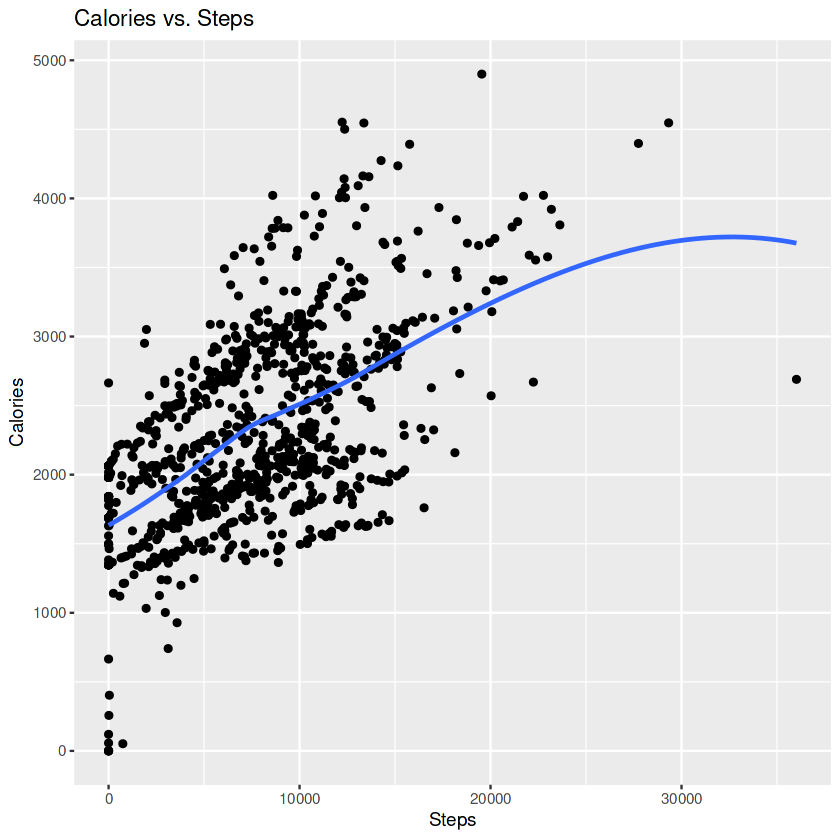

In [7]:
ggplot(data = activity, aes(x=TotalSteps, y=Calories)) +
  geom_point() + geom_smooth(se=FALSE) + labs(title = "Calories vs. Steps", x="Steps")

**Time in Bed vs Time Asleep**  
The average hours slept is about 7 hours with most people sleeping between 6-9 hours. Although most the data looks linear there are some data points that show people are in bed longer than there are sleeping. There could be a number of reasons for this, but one is that people use their phones while in bed. Studies have shown that using your phone after waking  up or before going to sleep is bad. To improve quality of sleep maybe the watch can notify users they've been in bed sleep long while being awake.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



[1] 419.1732

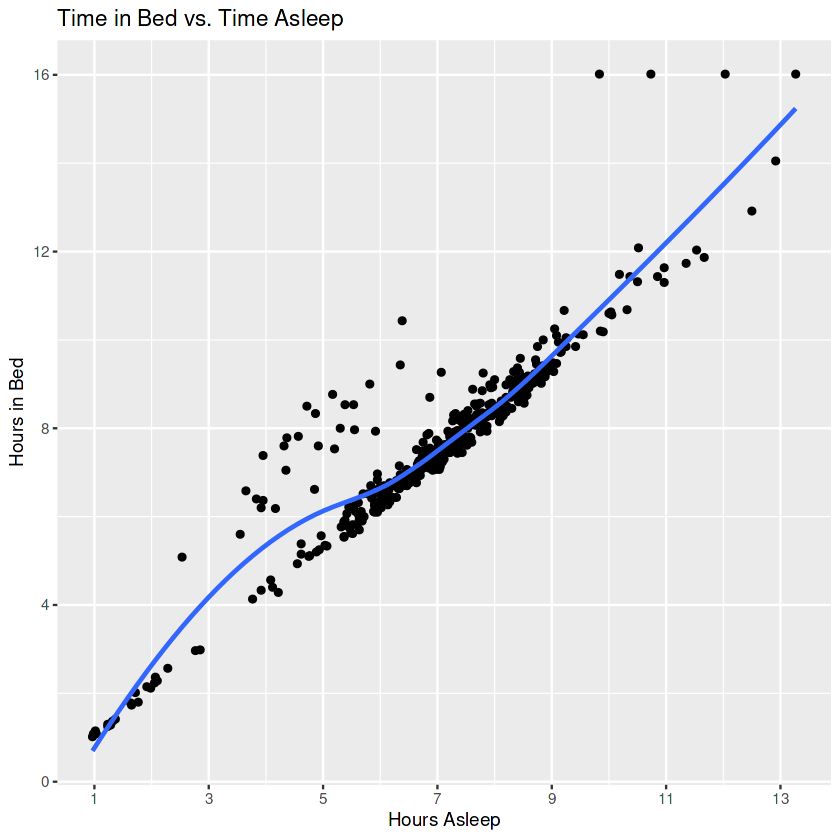

In [8]:
ggplot(data = sleep, aes(x=TotalHoursAsleep, y=TotalHoursInBed)) +
  geom_point() +
  scale_x_continuous(breaks = round(seq(min(sleep$TotalHoursAsleep),
                                        max(sleep$TotalHoursAsleep), by = 2),1)) +
  geom_smooth(se=FALSE) +
  labs(title = "Time in Bed vs. Time Asleep", x="Hours Asleep", y="Hours in Bed")

mean(sleep$TotalMinutesAsleep)

**Daily Steps vs Hours Asleep**  
There appears to be no correaltion between these two variables.

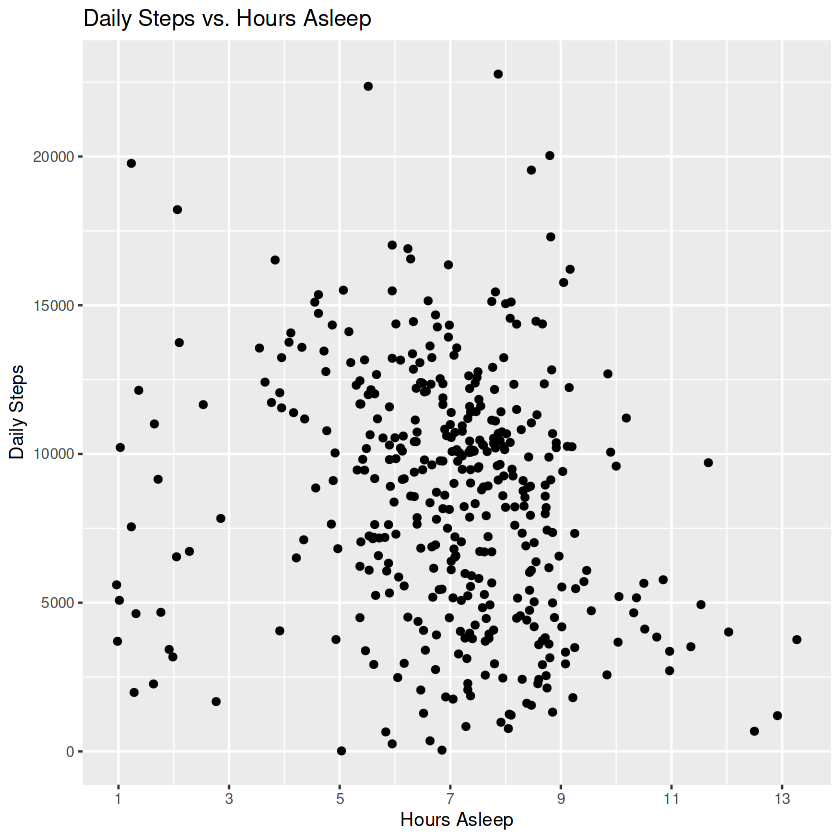

In [9]:
ggplot(data=merged_data, aes(x=TotalHoursAsleep, y=TotalSteps)) +
  geom_point() +
  scale_x_continuous(breaks = round(seq(min(merged_data$TotalHoursAsleep),
                                        max(merged_data$TotalHoursAsleep), by = 2),1)) +
  labs(title="Daily Steps vs. Hours Asleep", x="Hours Asleep", y="Daily Steps")

#### **4.3 Distributions**
**Average Number of Steps per Hour**  
The busiest hours are between 6pm and 7pm which makes sense since it's probably when people get 
back from work. There is a dip at 3pm which might due to people eating lunch.

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


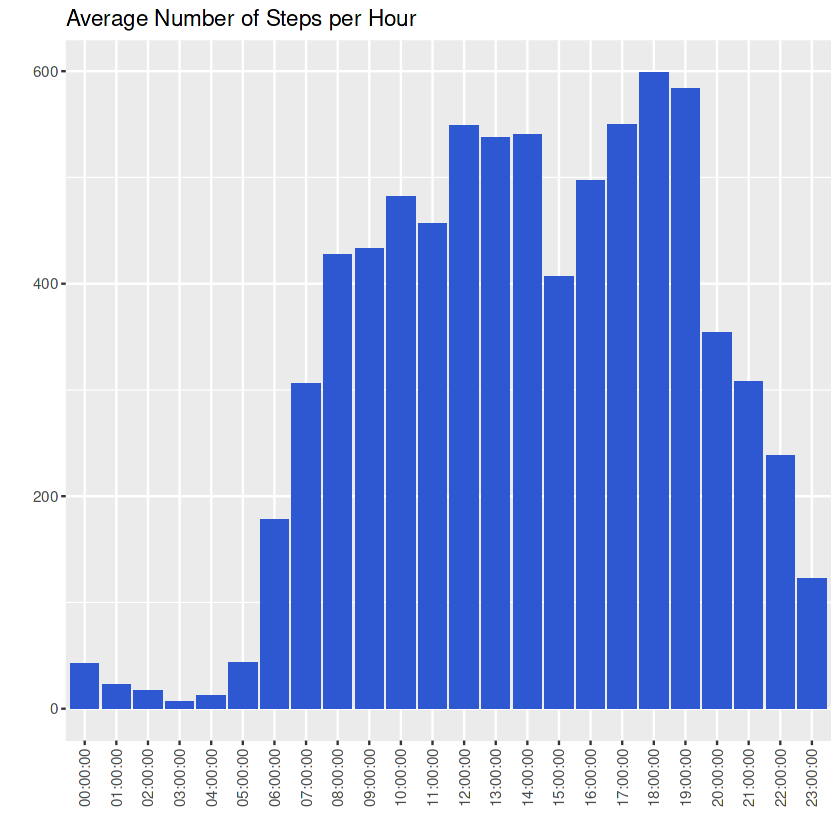

In [10]:
hourly_average_steps <- hourly_steps %>%
  group_by(Time) %>%
  summarize(Average_Steps = mean(StepTotal))
  
ggplot(hourly_average_steps, aes(x=Time, y=Average_Steps)) +
  geom_histogram(stat = "identity", fill="#2d58d2") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  labs(title="Average Number of Steps per Hour", x='', y='')

**Distribution of steps throughout the week**  
People are most active in the begining of the week and Saturdays. Sunday is the only day where the average dips below 7,000, this is probably because Sundays are typically seen as rest days.

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


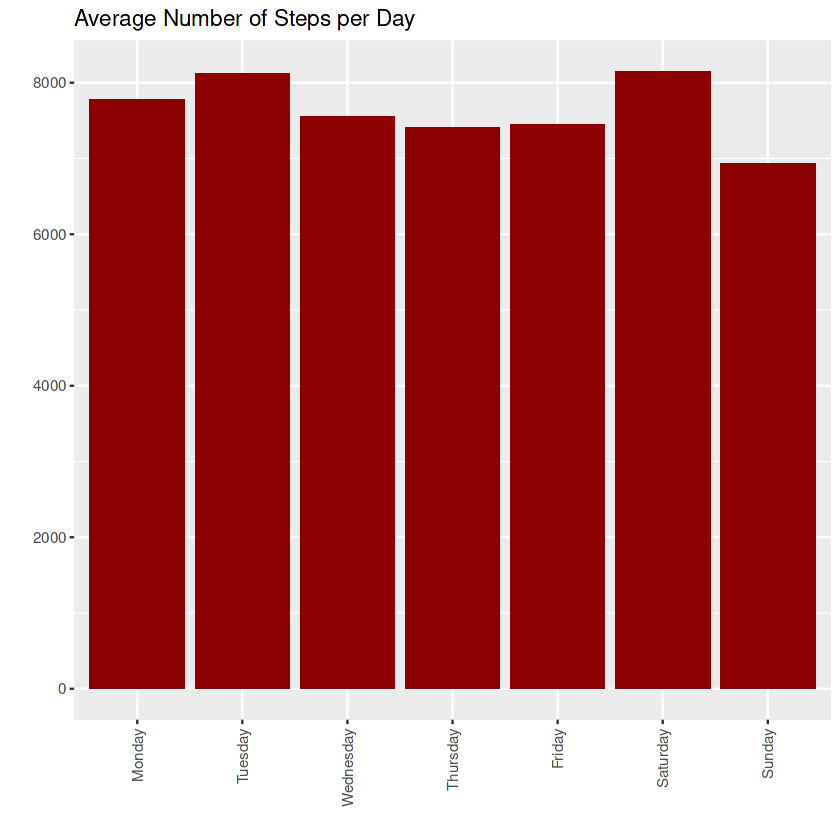

In [11]:
activity$Day <- weekdays(as.Date(activity$Date))
daily_activity <- activity %>%
  group_by(Day) %>%
  summarize(Average_Steps = mean(TotalSteps))

daily_activity$Day <-ordered(daily_activity$Day, levels=c("Monday", "Tuesday", "Wednesday", "Thursday",
"Friday", "Saturday", "Sunday"))

ggplot(daily_activity, aes(x=Day, y=Average_Steps)) +
  geom_histogram(stat = "identity", fill="Dark Red") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  labs(title="Average Number of Steps per Day", x='', y='')

**Boxplots of Calories burned and Total Steps per Sleep Type**  
I classified each user's sleep and activity levels in the merged activity and sleep dataset. For sleep I used the recommended 7-9 hours of sleep to label a good sleeper. Anything less is given the under sleeper label and anything more is given the over sleeper label.

For activity level I classified it using total steps as so:
* Sedentary less than 5,000 steps
* Low Active between 5000 and 7499
* Somewhat active between 7500 and 9999
* Active between 10000 and 12500
* Very active more than 12500  

Interestly, the median amount of calories burned and total steps for good sleepers and under sleepers is about the same. I explected the plots to look similar since we know there is a positive correlation between calories and steps taken. The median for oversleepers is the worst out of the three, one hypothesis could be is that they have less time to workout through their day.

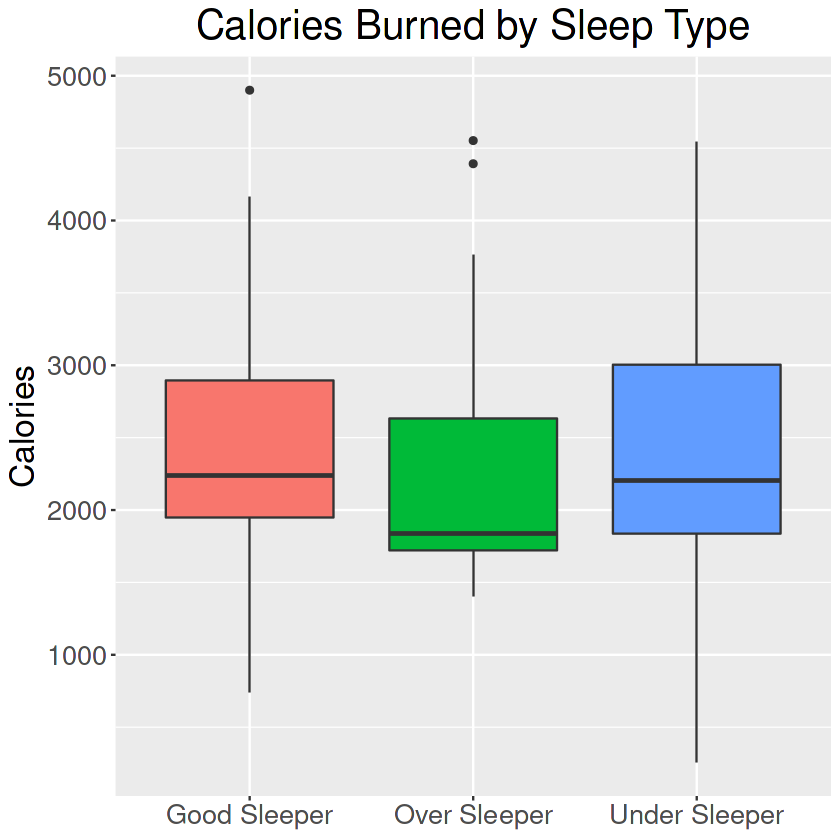

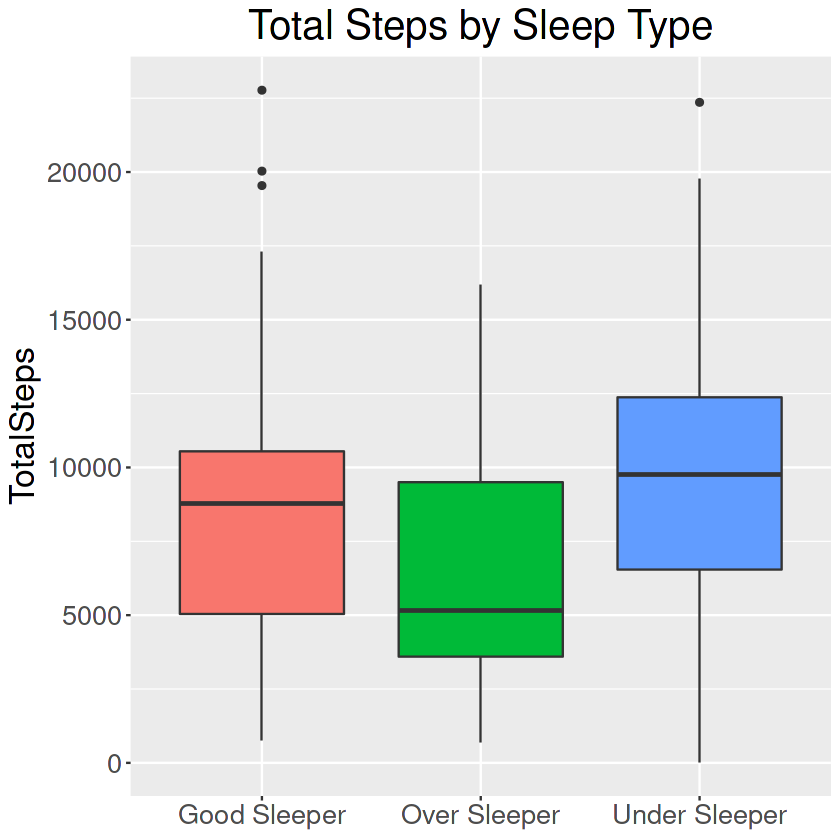

In [12]:
#Classifying each user sleep and activity levels
sleep_and_activity_levels <- merged_data %>%
  select(c("Id","Date", "TotalMinutesAsleep", "TotalSteps", "Calories")) %>%
  mutate(SleepQuality = case_when(
    TotalMinutesAsleep < 420 ~ "Under Sleeper",
    TotalMinutesAsleep >= 420 & TotalMinutesAsleep <= 540 ~ "Good Sleeper",
    TotalMinutesAsleep > 540 ~ "Over Sleeper"
  )) %>%
  mutate(ActivityLevel = case_when(
    TotalSteps < 5000 ~ "Sedentary",
    between(TotalSteps, 5000, 7499) ~ "Low Active",
    between(TotalSteps, 7500, 9999) ~ "Somewhat Active",
    between(TotalSteps, 10000, 12500) ~ "Active",
    TotalSteps > 12500 ~ "Highly Active"
  ))

ggplot(sleep_and_activity_levels, aes(SleepQuality, Calories, fill=SleepQuality)) +
    geom_boxplot() +
    theme(legend.position="none") +
    labs(title="Calories Burned by Sleep Type", x=NULL) +
    theme(legend.position="none", text = element_text(size = 20),plot.title = element_text(hjust = 0.5))

ggplot(sleep_and_activity_levels, aes(SleepQuality, TotalSteps, fill=SleepQuality)) +
    geom_boxplot() +
    theme(legend.position="none") +
    labs(title="Total Steps by Sleep Type", x=NULL) +
    theme(legend.position="none", text = element_text(size = 20),plot.title = element_text(hjust = 0.5))

**Composition**
The pie chart below shows the percentages of each activity level outlined previously. The percentage of people active and sedentary is just about equal.

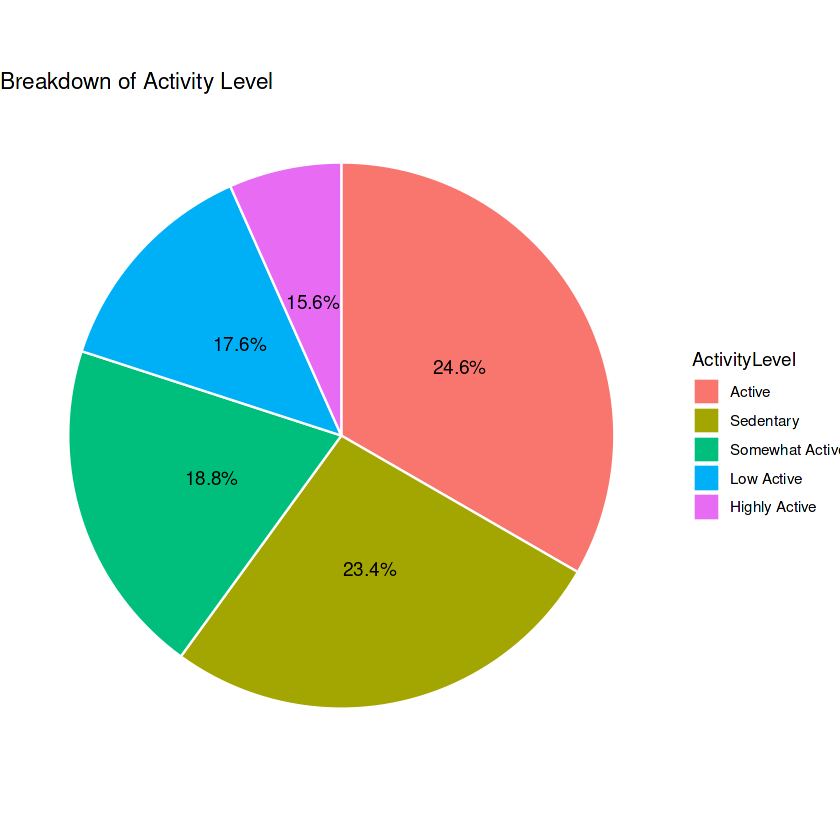

In [13]:
activity_comp <- sleep_and_activity_levels %>%
  group_by(ActivityLevel) %>%
  summarise(GroupSize = n()) %>%
  mutate(Totals = sum(GroupSize)) %>%
  mutate(Percent = scales::percent((GroupSize / Totals)))

activity_comp <- activity_comp[order(decreasing = TRUE, activity_comp$Percent),]
order <- activity_comp$ActivityLevel

ggplot(activity_comp, aes(x = "", y = Percent, fill = ActivityLevel)) +
  ggtitle("Breakdown of Activity Level") +
  geom_bar(stat="identity", width=1, color="white") +
  scale_fill_discrete(limits = order) +
  geom_text(aes(label = Percent), position = position_stack(vjust = 0.5)) +
  coord_polar(theta = "y") +
  theme_void()

# **5. Conclusion (Act)**  

After analysis on how consumers use other non-Bellabeat smart wearable devices, I gained insights on trends that can help the Bellabeat marketing strategy.  
1. **Daily step goals tailored specifically for the user:**  
For example, if a person is just starting the goal can be 7,500 steps. As the user starts tracking more steps daily, the goal can be increased to motivate more activity. Also if they start trending lower steps than the goal can be decreased slightly to make the goals reasonable. From my analysis there is a clear postive correaltion between calories burned vs steps taken. However, people start off on different activity levels, an sedentary person should not be expected to reach the same goals an active person has.  
2. **Promote the optimization of sleep:**
Although my analysis show no correlation between daily steps and hours slept, this does not sleep for the quality of sleep and exercise one has. Moreover, further analysis did show that an oversleepers average amount of steps is significantly less than a good sleeper or undersleeper. To combat this the watch can send notifications about when to sleep,depending on when the person wants to awake. It could also nudge people in morning who spend more time in bed, perhaps on their phones, after waking up.  
3. **Target sedentary people:**
If I were to guess most people who get a fitness tracker either do so because they're either already active, or they're wanting to be active. My analysis seems to support that analysis as most days logged fell under the active category (10,000-12,500 daily steps) at 24.6% of the total days. However, the second most popular category was sedentary (less than 5,000 daily steps) at 23.4%, only 1.2% less. This is a huge gap in daily steps between the top two categories, so more effort should be done on motivating sedentary people. Such as encouraging a walk outside after sensing sedetary activity for too long, stretch breaks, or working out after a day of sedentary work. The watch can show how long the user has been sedentary as more moitvation, in case a user does not even realize how much they spend sitting.
